##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [24]:
headers=['Interval','Timestamp','Flume Depth (mm)','AV Flow (L/s)', 'Flume Flow (L/s)', 'Precipitation (mm)']
df = pd.read_csv ('central1_sani.csv', names=headers)
df=df[1:]
# df=df.astype(float)
df.head()

,Interval,Timestamp,Flume Depth (mm),AV Flow (L/s),Flume Flow (L/s),Precipitation (mm)
1,15 Min,2021-04-01 0:15,14.16,0.4,0.22,0
2,15 Min,2021-04-01 0:30,14.95,0.24,0.29,0
3,15 Min,2021-04-01 0:45,14.88,0.15,0.21,0
4,15 Min,2021-04-01 1:00,13.1,0.17,0.21,0
5,15 Min,2021-04-01 1:15,13.96,0.23,0.21,0


TypeError: ignored

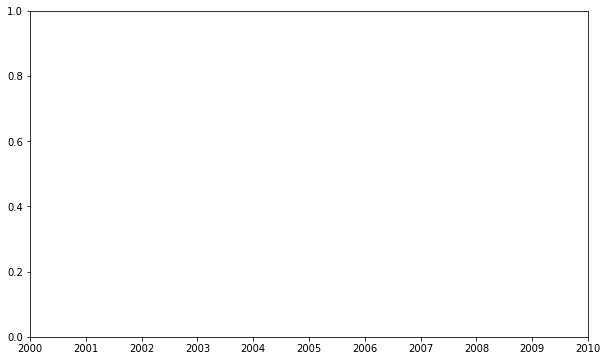

In [27]:
# time = np.arange(4 * 365 + 1)
time=pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:' )

# date_time = pd.to_datetime(df.pop('Timestamp'), format='%Y-%m-%d %H:%M:')
# slope = 0.05
# baseline = 10
# amplitude = 40
# series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series = df['AV Flow (L/s)']
# noise_level = 5
# noise = white_noise(time, noise_level, seed=42)



plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [31]:
series

1         0.4
2        0.24
3        0.15
4        0.17
5        0.23
         ... 
26395     NaN
26396     NaN
26397     NaN
26398     NaN
26399     NaN
Name: AV Flow (L/s), Length: 26399, dtype: object

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [7]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [10]:
split_time = 1000
time_train = date_time[:split_time]
x_train = series[:split_time]
time_valid = date_time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

ValueError: ignored

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [ ]:
lin_forecast.shape

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

### Dense Model Forecasting

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 1s 3ms/step - loss: 43.8270 - mae: 44.3262 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 41.5210 - mae: 42.0202 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 38.6253 - mae: 39.1248 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 35.3203 - mae: 35.8201 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 31.5905 - mae: 32.0903 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 27.4033 - mae: 27.9022 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 22.7830 - mae: 23.2804 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 17.7632 - mae: 18.2594 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 12.6771 - mae: 13.1682 - lr: 2.5119

(1e-07, 0.005, 0.0, 30.0)

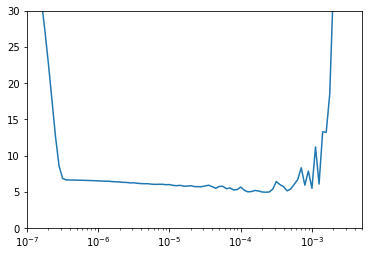

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 1s 13ms/step - loss: 20.4049 - mae: 20.8986 - val_loss: 9.5125 - val_mae: 10.0037
Epoch 2/500
31/31 [==============================] - 0s 7ms/step - loss: 8.6179 - mae: 9.1027 - val_loss: 7.5804 - val_mae: 8.0585
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 7.9849 - mae: 8.4702 - val_loss: 7.2411 - val_mae: 7.7189
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 7.6780 - mae: 8.1603 - val_loss: 7.0971 - val_mae: 7.5798
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 7.4285 - mae: 7.9136 - val_loss: 6.6877 - val_mae: 7.1663
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 7.2165 - mae: 7.6989 - val_loss: 6.7449 - val_mae: 7.2319
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 7.0491 - mae: 7.5318 - val_loss: 6.3436 - val_mae: 6.8156
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 6.9028 - mae: 7.38

In [19]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

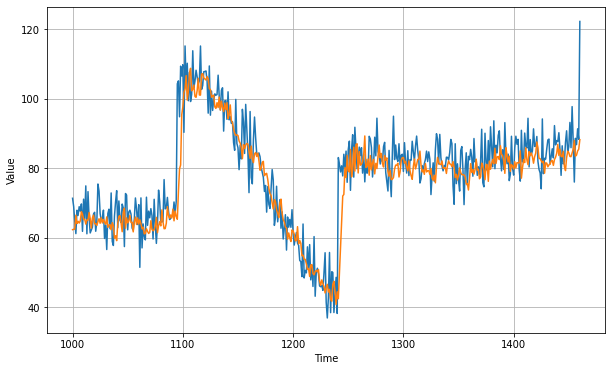

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [21]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.2025537